# Names and IDs
 1. Alon Malach 207024878
 2. Or Eitan 315681767

# I. Condorcet's Jury Theorem (1785)

Assume voter probability to be correct as $p>.5$.

1. Plot the probability a jury of $n$ voters (odd) is correct as a function of $p$ for different $n$ using Monte-Carlo simulations (sampling and averaging).

2. Prove that as number of jury members grows, $n\rightarrow\infty$, the  jury majority becomes correct  $\Pr(\text{correct}) \rightarrow 1$ (**hint**: use the law of large numbers).

Notes: Avoid loops where possible.

###I.1

In [1]:
import numpy as np
import pandas as pd
from scipy import special
import plotly.express as px
import plotly.graph_objects as go

In [2]:
def calc_majorty(n,p):

    majorty_from_n = int(np.ceil(n/2)) # get majorty value
    
    # - first column: total number of voters, second column: number of voters who vote correct
    df = pd.DataFrame(index=range(majorty_from_n),columns=['N_Members', 'K_Voters_Correct', 'N_Chose_K', 'Prob_Correct'])
    df['N_Members'] = n # set all the values in column to be n

    # since we are intersting on the majorty we will inset to df only rows which
    # the number of voter is equal or above the majorty number 
    df['K_Voters_Correct'] = df.index + majorty_from_n 
    
    # - third column: calcuation of n chose k
    df['N_Chose_K'] = special.comb(df['N_Members'], df['K_Voters_Correct'])
    
    # - forth column: calculate the binomial probability
    df['Prob_Correct'] = np.multiply(df['N_Chose_K'] ,np.power(p, df['K_Voters_Correct'])*(np.power(1-p ,(df['N_Members']-df['K_Voters_Correct']))))

    # since the probabilty are independent we will sum them
    return sum(df['Prob_Correct'])


In [3]:

def plot_graph(num_of_voters):

  p_list = np.sort(np.random.uniform(low=0.5, high=1.0, size=1000))# list of all the probabilities from 0 to 1
  
  # loop over array of numbers of voters in jury
  # loop over array of probabilities from 0.5 to 1
  # get probabilty of jury to be correct
  list_majority_for_all_n = [(voters,[calc_majorty(voters,num) for num in p_list]) for voters in num_of_voters]
  
  # setting tarce line
  fig = go.Figure()
  for item in list_majority_for_all_n:
    fig.add_trace(go.Scatter(x=p_list, y=item[1], name='n={}'.format(item[0])))
    
  # setting layout
  fig.update_layout(
      legend=dict(y=0.05, x=0.73),
      title={
        'text': "Condorcet's jury theorem",
        'y':0.88,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    autosize=False,
    width=500,
    height=500)
  fig.update_xaxes(title_text = "probability of vote correct p")
  fig.update_yaxes(title_text = "probability of jury to be correct")  
    
  return fig.show()

plot_graph([1,3,5,11,21,101])   


###I.2

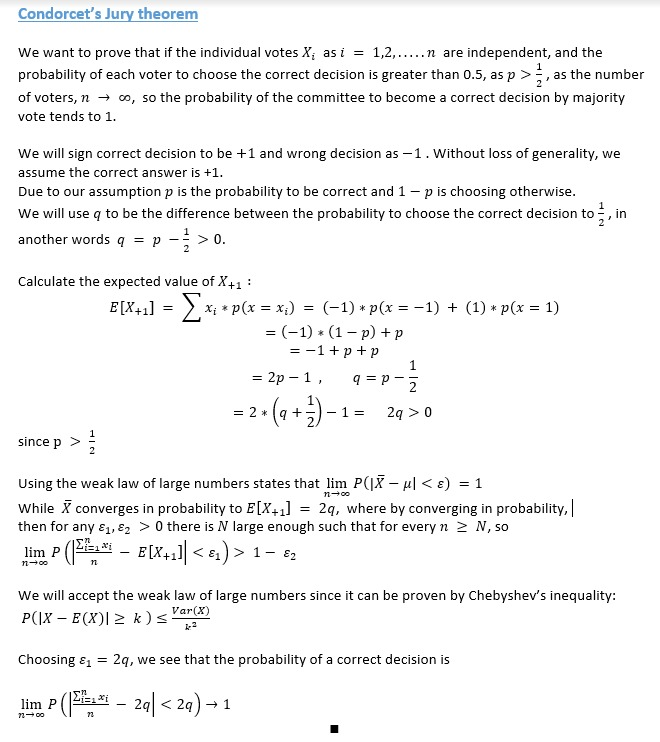

# II. AdaBoost
* Use `AdaBoostClassifier` model from sklearn.ensemble to find a strong classifier on the sample set given below, using $n$ weak learners:
    - For the base weak learners, use a ***linear*** SVM classifier (use `LinearSVC` from sklearn.svm) with the next parameters:
        - *tol=1e-10,loss='hinge', C=1000, max_iter=50000*
    - Split the sample set into 2/3rd train set and 1/3 test set.
    - Train ensemble classifiers where each has a different number of estimators $n\in \{1, 3, 10, 50, 100, 1000, 10000\}$.
    - Use the given function plot_data or your own function to plot the final decision plane of each ensemble model.

* Answer to the next questions:

 1. How does the overall train set accuracy change with $n$?
 2. Does your model start to overfit at some point? How can you test and detect such a point?
 3. For this specific task, what is the optimal number of estimators? Hint: use `estimator_errors_` attribute.

 ---
 **Note1:** 
 1. If ***linearSVC*** doesn't work, you can use ***SVC*** with: `kernel='linear'` and `probability=True`.
 2. Explain you results in text and support it with figures.

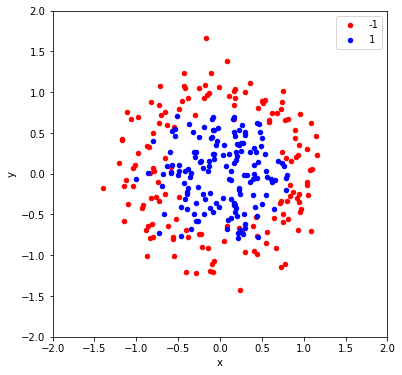

In [5]:
from sklearn.datasets import make_circles
from matplotlib import pyplot as plt
from pandas import DataFrame

# generate 2d classification dataset
X, y = make_circles(n_samples=300, noise=0.2, random_state=101, factor=0.5)
y = y*2 - 1
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {-1:'red', 1:'blue'}
fig, ax = plt.subplots(figsize=(6,6))
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.show()

In [6]:
def plot_data(X, y, h, ax):
    '''Plotting function. The function will plot the given instances as well will color the
    background according to the decision boundaries of the model.
    X - 2D array
    y - Vector of labels
    h - A function which accepts X and returns the predicted labels. It should be based on the trained model.
    ax - axes.Axes object as returned by matplotlib.pyplot.subplots function.'''
    def make_meshgrid(x, y, h=.01):
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
        return xx, yy
  
    def plot_contours(ax, clf, xx, yy, **params):
        Z = h(np.c_[xx.ravel(), yy.ravel()])  # predictions
        Z = Z.reshape(xx.shape)
        if 'levels' in params and len(params['levels'])<2:
          out = ax.contour(xx, yy, Z, **params, colors='k', edgesize=10)
        else:
          out = ax.contourf(xx, yy, Z, **params)
        return out
  
    # scatter plot, dots colored by class value
    df = DataFrame(dict(x0=X[:,0], x1=X[:,1], label=y))
    colors = {-1:'red', 1:'blue'}
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x0', y='x1', 
                 alpha=0.5, label=key, color=colors[key])
  
    # decision boundary
    xx1, xx2 = make_meshgrid(X[:,0], X[:,1])
    plot_contours(ax, h, xx1, xx2, alpha=0.2)#, levels=[0.5])
  
    ax.axis('scaled')

In [7]:
# Implement here:

In [8]:
from sklearn.ensemble import AdaBoostClassifier as adaboost
from sklearn.svm import LinearSVC 
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import subplots
from sklearn.metrics import accuracy_score

for n_estimators= 1 train_accuracy= 0.61 test_accuracy= 0.54 avg estimator err: 0.3900000000000001
for n_estimators= 3 train_accuracy= 0.63 test_accuracy= 0.65 avg estimator err: 0.42590328610147915
for n_estimators= 10 train_accuracy= 0.645 test_accuracy= 0.68 avg estimator err: 0.4575931503246835
for n_estimators= 50 train_accuracy= 0.695 test_accuracy= 0.6 avg estimator err: 0.740683826945007
for n_estimators= 100 train_accuracy= 0.695 test_accuracy= 0.6 avg estimator err: 0.8703419134725036
for n_estimators= 1000 train_accuracy= 0.695 test_accuracy= 0.6 avg estimator err: 0.9870341913472503
for n_estimators= 10000 train_accuracy= 0.695 test_accuracy= 0.6 avg estimator err: 0.9987034191347252


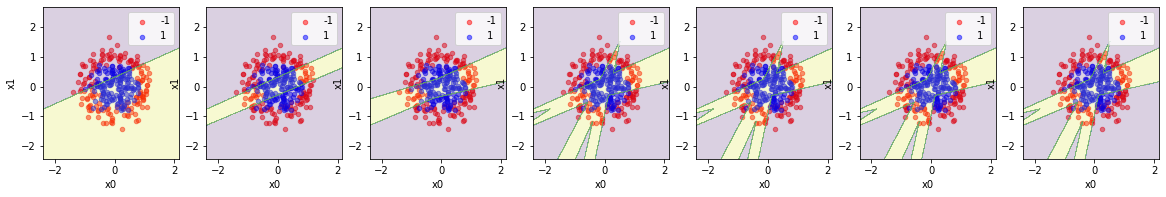

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=6002)
n_ls = [1, 3, 10, 50, 100, 1000, 10000]
fig, ((ax0, ax1, ax2, ax3, ax4, ax5, ax6)) = plt.subplots(1, 7, figsize=(20,20))
ax_ls = [ax0, ax1, ax2, ax3, ax4, ax5, ax6]
ls_train_accuracy_score, ls_test_accuracy_score = [], []
for n in range(len(n_ls)):
  ada = adaboost(LinearSVC(tol=1e-10, loss='hinge', C=1000, max_iter=50000), n_estimators=n_ls[n], algorithm='SAMME', random_state=6083)
  ada.fit(X_train,y_train)
  plot_data(X=X, y=y, h=ada.predict, ax=ax_ls[n])
  train_accuracy, test_accuracy = accuracy_score(y_train, ada.predict(X_train)), accuracy_score(y_test, ada.predict(X_test))
  ls_train_accuracy_score.append(train_accuracy)
  ls_test_accuracy_score.append(test_accuracy)
  print('for n_estimators=', n_ls[n], 'train_accuracy=', train_accuracy, 'test_accuracy=', test_accuracy, 'avg estimator err:', np.average(ada.estimator_errors_))

#### Answer



#Answers:
##Section 1
Train accuracy result printed in the block above (caculated using sklearn.metrics) and also vizualized below (until n=100 in order to see this clrearly, it doesn't change the meaning). <br/>
We can see that the accuracy increased as well as the number of estimators until it gets train accuracy= 0.695 (for 50  estimators) but then its remain the same altough the number of estimator increasing.
It can be seen in the printed results. (also in the plot)<br/>

<br/>


In [10]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=n_ls[:-2],
                         y=ls_train_accuracy_score,
                         mode='lines+markers',
                         name='Train'))

fig.update_layout(
      legend=dict(y=0.05, x=0.9),
      title={
        'text': 'Train accuracy_score',
        'y':0.88,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    autosize=False,
    width=1000,
    height=500)
fig.update_yaxes(title_text = "Train accuracy scores")
fig.update_xaxes(title_text = "Number of estimators")
fig.show()

##Section 2
For this section, We added the train accuracy. (and vizualization for the train and test acuuracy score) <br/>So, Yes our model start to overfit at some point, We can see this happening clearly when for 10 estimators we get the max argument for the test accuracy, and when we adding more estimators the test accuracy decrease as well as the train accuracy increasing. (we looked for sprecial seed until we got seed that help us see this difference clearly).<br/>
In general - for testing and detecting such a point -  We can tuning the number of estimators and change the validation mothod.<br/> Extension for explanation - In general, AdaBoost has potential to overfit the training set because it focuses on misclassified examples, which may be noisy.<br/>
While, validation set adjusts the weights of the hypotheses. The hypotheses generated by all subsets are then aggregated with a weighted
plurality vote for final classification.<br/>
<br/>
More over, We saw in class that test-set validation(as we used) can consume Variance (which lead to unreliable estimate of future performance) so we can apply another kind of validation (e.g k-fold cross validation, It depeneds on how important to us is running time etc..) for each number of estimators and find the optimum (In our example, we set seed that also show (even with test-set validation) that 10 estimators gain better prefromance than more.<br/> (we took few minutes to find a seed who gives us more clear overfiting - accuracy decreased when adding more classifires).<br/>

In [11]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=n_ls[:-2],
                         y=ls_train_accuracy_score,
                         mode='lines+markers',
                         name='Train'))

fig.add_trace(go.Scatter(x=n_ls[:-2],
                         y=ls_test_accuracy_score,
                         mode='lines+markers',
                        name='Test')) # hover text goes here))

fig.update_layout(
      legend=dict(y=0.05, x=0.9),
      title={
        'text': 'Train and Test accuracy_score',
        'y':0.88,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    autosize=False,
    width=1000,
    height=500)
fig.update_yaxes(title_text = "Accuracy scores")
fig.update_xaxes(title_text = "Number of estimators")
fig.show()

##Section 3:
In section 2, we have explained how to find the point that the model start to overfit. Actually the best number of estimators will be before the overfitting is starting and the average estimator error is minimal. In our example the lowest average estimator error is for one estimator but obviously one weak estimator is not the functioning as well as more boosting of weak estimators. <br/>So for our given data, experiment and the results above, 10 estimators is the best number. *We also have implement for looking for the optimal number of estimators* - we know for sure that the optimum point is greater than 3 but smaller than 50. because we saw that the overfiting starts from n_estimators<= 50, so we are looking from 3 to 50.<br/>
  **In conclusion - 7 is the optimal number of estimators (in terms of avg estimator error, and looking for best accuracy (because it's get better estimator error for 3 estimators but the accuracy is not optimal))<br/> In other words, 7 estimators gives us maximum accuracy and minimum estimator error.**
<br/>
Below - numerical results and plot for vizualizing.

In [12]:
new_search_space = range(3,50)
ls_avg_estimator_err, ls_test_accuracy_score = [], []
for n in new_search_space:
  ada = adaboost(LinearSVC(tol=1e-10, loss='hinge', C=1000, max_iter=50000), n_estimators=n, algorithm='SAMME', random_state=6083)
  ada.fit(X_train,y_train)
  accuracy = accuracy_score(y_test, ada.predict(X_test))
  avg_est_err = np.average(ada.estimator_errors_)
  ls_test_accuracy_score.append(accuracy)
  ls_avg_estimator_err.append(avg_est_err)
  print('for n_estimators=', n, 'test_accuracy=', accuracy, 'avg estimator err:', avg_est_err)

for n_estimators= 3 test_accuracy= 0.65 avg estimator err: 0.42590328610147915
for n_estimators= 4 test_accuracy= 0.65 avg estimator err: 0.4394471124953586
for n_estimators= 5 test_accuracy= 0.54 avg estimator err: 0.4430683270865986
for n_estimators= 6 test_accuracy= 0.54 avg estimator err: 0.4497130598953749
for n_estimators= 7 test_accuracy= 0.68 avg estimator err: 0.4484280896062402
for n_estimators= 8 test_accuracy= 0.67 avg estimator err: 0.45261305771863314
for n_estimators= 9 test_accuracy= 0.68 avg estimator err: 0.4542209989809125
for n_estimators= 10 test_accuracy= 0.68 avg estimator err: 0.4575931503246835
for n_estimators= 11 test_accuracy= 0.54 avg estimator err: 0.4552937165037647
for n_estimators= 12 test_accuracy= 0.67 avg estimator err: 0.45608680585364386
for n_estimators= 13 test_accuracy= 0.67 avg estimator err: 0.4577721818749248
for n_estimators= 14 test_accuracy= 0.64 avg estimator err: 0.4565429753004668
for n_estimators= 15 test_accuracy= 0.68 avg estimator e

In [13]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(new_search_space),
                         y=ls_avg_estimator_err,
                         mode='lines+markers',
                         name='Estimator_err'))
fig.add_trace(go.Scatter(x=list(new_search_space),
                         y=ls_test_accuracy_score,
                         mode='lines+markers',
                        name='Accuracy')) # hover text goes here))

fig.update_layout(
      legend=dict(y=0.05, x=0.8),
      title={
        'text': 'Estimator error and (test) accuracy_score',
        'y':0.88,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    autosize=False,
    width=1000,
    height=500)
fig.update_yaxes(title_text = "Average estimator err and accuracy")
fig.update_xaxes(title_text = "Number of estimators")
fig.show()